In [2]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.optimize as op
import scipy.stats as stt
from sklearn.decomposition import PCA
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

In [3]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [4]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

In [5]:
import mecll

In [6]:
sys.path.append("/Users/yves/Documents/Code/mec_ephys/packages/mecll/dynamics/")

In [7]:
from unitary_dynamics import *

In [8]:
def load_data(selected_session,by_dir=False):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    if by_dir:
        firing_rate_maps = get_task_responses_by_direction(task_event_df,response_table)
    else:
        firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df,seq0,seq1,graph_type0,graph_type1

In [29]:
def get_task_responses_by_direction(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [30]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            #for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
            table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                            (task_event_df['correct']==True) &  #the poke was to the correct port
                                            (task_event_df['port']==port)        #the port poked was port
                                            #(task_event_df['direction']==direction)
                                           ].index           
            #print(len(table_index))
            #get the average
            firing_rate_maps[:,int(port),int(task)] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps

In [31]:
def zscore_population_activity(dat):
    out = (dat - np.mean(dat,axis=0))/np.std(dat,axis=0)
    out = out[:,~np.isnan(np.sum(out,axis=0))]
    return out

In [110]:

firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(0)
mds_frm = firing_rate_maps.swapaxes(0,2)
mds_frm = zscore_population_activity(np.vstack(mds_frm))
act_matrix = mds_frm[:9][seq0]
act_matrix2 = mds_frm[9:][seq1]
mds_frm = np.dstack([act_matrix,act_matrix2]).swapaxes(0,2).swapaxes(1,2)
print(graph_type0,graph_type1)

loop loop


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [97]:
act_matrix2.shape

(9, 128)

In [98]:
grad_predict_all = grad(predict_all)

In [99]:
from sklearn.decomposition import PCA
pca_dim = 8
pca = PCA(n_components=pca_dim)

In [100]:
mds_frm.shape

(2, 9, 128)

In [101]:
pca.fit(np.vstack(mds_frm))
pca_activity = pca.transform(mds_frm[0])
pca_activity2 = pca.transform(mds_frm[1])

In [102]:
pca_activity.shape

(9, 8)

In [103]:
n_params = int(pca_dim*(pca_dim-1)/2)
basis_tensor_inf = get_basis_tensor(pca_dim)

params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (pca_activity,pca_dim,basis_tensor_inf),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

Desired error not necessarily achieved due to precision loss.


In [104]:
print(res.fun,res.message)

79.4623794555664 Desired error not necessarily achieved due to precision loss.


In [105]:
out = res.x
#out = np.random.normal(size=(n_params))# + np.eye(dim)

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [106]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity.T).T)

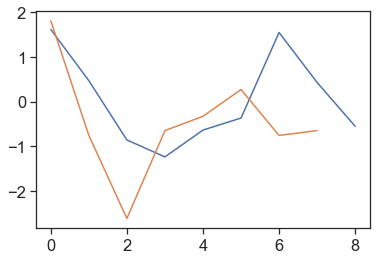

In [107]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_])
plt.plot(act_matrix[:,ix_][1:])

In [108]:
#seaborn.distplot(np.array(cc)[~np.isnan(cc)],kde=0)

In [109]:
cc = []
n_neurons = act_matrix.shape[1]
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
    
print(np.nanmean(cc))

0.5468457068080417


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## Now try other direction


In [72]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity2.T).T)

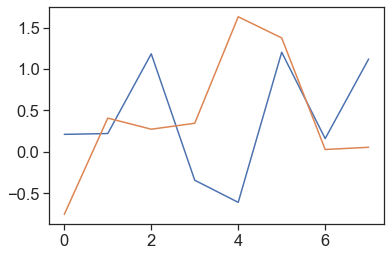

In [73]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_][:-1])
plt.plot(act_matrix2[:,ix_][1:])

In [111]:
true_cc = []
print(act_matrix2[:,0])
for i in range(n_neurons):
    true_cc.append(np.corrcoef(act_matrix2[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
    
true_cc = np.nanmean(true_cc)
print(true_cc)

[ 0.46649075 -0.753552    0.40786169  0.27385242  0.3455318   1.63002626
  1.37464287  0.02923232  0.05591815]
-0.25428533843840734


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
[-0.36952234 -0.78147718 -0.08939304  0.36349151  0.29372497 -0.42719602
 -1.20991022 -1.23987058 -0.76170335]


In [75]:
all_cc = []
for _ in range(200):
    cc = []
    new_order = np.random.permutation(np.arange(9))
    for i in range(n_neurons):
        cc.append(np.corrcoef(act_matrix2[:,i][new_order][1:],predicted_neural_activity[:,i][:-1])[0,1])
    all_cc.append(np.nanmean(cc))
#print(np.nanmean(cc))

In [782]:
act_matrix.shape

(9, 198)

In [783]:
predicted_neural_activity.shape

(9, 198)

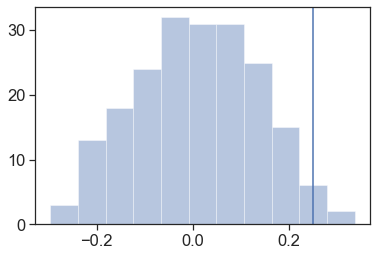

In [784]:
seaborn.distplot(all_cc,kde=0)
plt.axvline(x=true_cc)

In [450]:
np.allclose(act_matrix,act_matrix2)

False

In [451]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix2[:,i][np.random.permutation(np.arange(9))],np.roll(predicted_neural_activity[:,i],1))[0,1])
    
print(np.nanmean(cc))

0.0010682029002643673


# Now implement this as a batch thing

In [141]:
def fit_data(neural_activity1,neural_activity2,pca_activity1,pca_activity2,pca):
    pca_dim = pca_activity.shape[1]
    fit_params = []
    fit_quality = []
    for _ in range(5):
        n_params = int(pca_dim*(pca_dim-1)/2)
        basis_tensor_inf = get_basis_tensor(pca_dim)

        params = np.random.normal(size=(n_params))# + np.eye(dim)
        res = op.minimize(predict_all,
                   params,
                   (pca_activity1,pca_dim,basis_tensor_inf),
                   jac=grad_wrapper,
                   method='BFGS'
                   )
        out = res.x
        #out = np.random.normal(size=(n_params))# + np.eye(dim)

        skewM = np.einsum('i...,i...',out,basis_tensor_inf)
        Ainf = caley_transform(skewM,pca_dim)
        #print(res.message)

        predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity1.T).T)
        fit_params.append(out.copy())
        fit_quality.append(evaluate_cc(neural_activity1,predicted_neural_activity))
    params = fit_params[np.argmax(fit_quality)]
    print(fit_quality)
    
    predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2.T).T)
    res = evaluate_cc(neural_activity2,predicted_neural_activity2)
    shuffle_res = []
    print(res)
    
    r9 = np.arange(9)

    for _ in range(2000):
        
        perm_order = np.random.permutation(r9)
        predicted_neural_activity2_shuff = pca.inverse_transform((Ainf@pca_activity2[perm_order].T).T)

        shf_res = evaluate_cc(neural_activity2[perm_order],predicted_neural_activity2_shuff)
        
        shuffle_res.append(shf_res)
    return res, shuffle_res
    

In [188]:
pca_activity.shape

(9, 8)

In [143]:
def evaluate_cc(activity,pred):
    n_neurons = activity.shape[1]
    true_cc = []
    #print(activity[:,0])

    for i in range(n_neurons):
        true_cc.append(np.corrcoef(activity[:,i][1:],pred[:,i][:-1])[0,1])

    true_cc = np.nanmean(true_cc)
    return np.nanmean(true_cc)

In [144]:
all_res = []
all_shuffle_res = []
for session_ix in range(8):

    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(session_ix)
    mds_frm = firing_rate_maps.swapaxes(0,2)
    mds_frm = zscore_population_activity(np.vstack(mds_frm))
    act_matrix = mds_frm[:9][seq0]
    act_matrix2 = mds_frm[9:][seq1]

    
    mds_frm = np.dstack([act_matrix,act_matrix2]).swapaxes(0,2).swapaxes(1,2)
    #print(graph_type0,graph_type1)
    pca_dim = 8
    pca = PCA(n_components=pca_dim)
    
    pca.fit(np.vstack(mds_frm))
    pca_activity = pca.transform(mds_frm[0])
    pca_activity2 = pca.transform(mds_frm[1])
    res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca)
    all_res.append(res)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.6041792976392968, 0.6949863293680906, 0.6865533113361891, 0.48378624518554686, 0.6865164816832581]
0.17136437598671111


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.542660402145225, 0.5326240392727616, 0.6097635606024401, 0.5750838062196182, 0.6706777161247661]
0.2327573033838518


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.6060251416565599, 0.7088738076177216, 0.6433959693419217, 0.6613045451376083, 0.6613010698399115]
0.24394553814989792


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.6815104664859877, 0.6646070116222552, 0.7794745892463076, 0.6373978508726202, 0.7794047610303462]
0.12155979800332571


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.49477895962673585, 0.6569687959143824, 0.6162691928130625, 0.6107109888999044, 0.6136342177746879]
0.014713673113269283


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[0.5516399041088348, 0.6532543154299959, 0.2841383013771625, 0.6545525405217136, 0.6530379036448324]
0.07227589507408853


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[0.5456385443800693, 0.5455987274729837, 0.5444039319677911, 0.5456339655374597, 0.5443873085392146]
0.04901646908524362


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/

[0.47422739746828124, 0.44090293331766817, 0.440965330733424, 0.46683645205795243, 0.5182609927259191]
-0.050747339906348034


In [146]:
real_res = [i[0] for i in all_res]
shuffle_res = [i[1] for i in all_res]

In [147]:
mean_real_pred_accuracy = np.mean(real_res)

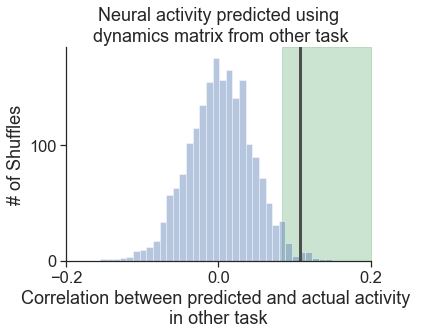

In [186]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task")
seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota
seaborn.despine()
plt.xlim(-.2,.2)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),.2],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

In [154]:
(100-stt.percentileofscore(np.nanmean(np.array(shuffle_res),axis=0),np.mean(real_res)))/100

99.2

In [187]:
(100-stt.percentileofscore(np.nanmean(np.array(shuffle_res),axis=0),np.mean(real_res)))/100

0.007999999999999972

In [191]:
np.std(np.random.normal(size=1000)*.1)

0.09972328097023579